<a href="https://colab.research.google.com/github/ck1972/Python-Geospatial_Model1/blob/main/6b_Hyperparameter_Tuning_Random_Forest_for_Land_Cover_in_GEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter Tuning Random Forest for Land Cover in GEE
## Introduction
### Overview
This tutorial integrates Sentinel-2 imagery, random forest classification, and hyperparameter tuning to achieve to improve land cover mapping.
The tutorial includes:
- Loading and preprocessing Sentinel-2 imagery for the study area.
-Creating a training datasest.
- Splitting the dataset into training and testing subsets.
- Training a random forest classifier and tuning its hyperparameters for optimal performance.
- Evaluating the model using accuracy metrics and confusion matrices.
- Generating a classified land cover map.


# Initialize and Authenticate Earth Engine
To get started with Google Earth Engine (GEE), you need to initialize and authenticate the Earth Engine API. Follow these steps.


First, import the Earth Engine API by importing the ee module into your Python environment. This module allows you to interact with the Earth Engine platform.

In [ ]:
# Import the EE API
import ee

Next, initialize the Earth Engine API. You must initialize the API to use Earth Engine functionalities. This involves authenticating your session and initializing the library. When you run the ee.Initialize() command for the first time, you might be prompted to authenticate your session. This will open a web browser window where you need to log in with your Google account and grant Earth Engine access.

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-kamusoko-test') # Change to your EE project

## Import Libraries
Next, import the essential libraries needed to process and analyze the datasets.

In [ ]:
# Import the necessary libraries
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Import Vector Datasets
First, import the study area boundary and training areas.

In [ ]:
# Load the boundary
boundary = ee.FeatureCollection('users/kamas72_ML_Zim_Cities/Bulawayo_Crop_Boundary')

# Load the boundary
training_areas = ee.FeatureCollection('users/kamas72_ML_Zim_Cities/Updated_TA_2020_Bul_May_21_GEE')

## Prepare Sentinel-2 Imagery
First, preprocess Sentinel-2 imagery by first applying cloud masking to remove cloud and cirrus pixels using the QA60 band. Then load Sentinel-2 surface reflectance images within a specified date range and filters them based on cloud cover, retaining images with less than 20% cloudiness. A median composite is generated from the filtered images and clipped to a specified boundary region. Finally, the composite is visualized as a false-color image using selected bands on an interactive map, complete with layer control for enhanced usabilit

In [ ]:
# Function for Cloud Masking
def mask_s2clouds(image):
    qa = image.select('QA60')
    cloudBitMask = ee.Number(2).pow(10).int()
    cirrusBitMask = ee.Number(2).pow(11).int()
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000)

# Load Sentinel-2
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate('2024-03-01', '2024-06-30') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(mask_s2clouds) \
    .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12'])

# Clip the composite
composite = s2.median().clip(boundary)

# Print Sentinel-2 Composite
print('Sentinel-2 Composite:', composite.getInfo())

# Display the Sentinel-2 composite
# Initialize the map
map1 = geemap.Map()

# Add the composite image to the map with specified display settings.
map1.addLayer(composite, {'bands': ['B11', 'B8', 'B3'], 'min': 0, 'max': 0.3}, 'Sentinel-2 Composite')

# Display the map with layer control.
map1.centerObject(boundary, 12)
map1.addLayerControl()
map1

Sentinel-2 Composite: {'type': 'Image', 'bands': [{'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B6', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B7', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'crs': 'EPSG:4326'

Map(center=[-20.112185699155855, 28.554695214742292], controls=(WidgetControl(options=['position', 'transparen…

## Prepare Training and Testing Data
### Rasterize training areas
In this step, we prepare the dataset for training and testing machine learning models by processing satellite imagery and training labels. We start by selecting Sentinel-2 bands (B2 to B12) and clipping the composite image to the specified boundary region, defining the input features. Next, we rasterize the vector training data using the Cl_Id property to create a raster layer representing class labels and add it as a new band (class) to the input features.

In [ ]:
# Use ee.List for band selection
bands = ee.List(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12'])
input_features = composite.clip(boundary)
print('input features: ', input_features.getInfo())

# Rasterise training data
training_rasterized = training_areas.reduceToImage(
    properties=['Cl_Id'],
    reducer=ee.Reducer.first()
).toInt().remap([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]) # Bare areas, Built-up, Cropland, Grass/ open areas, Woodlands, Water

# Add a class band to features
input_features = input_features.addBands(training_rasterized.toInt().rename('class'))

input features:  {'type': 'Image', 'bands': [{'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B6', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B7', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'crs': 'EPSG:4326', 'cr

### Sample the dataset
To create a representative dataset, we use stratified sampling to extract reflectance values and class labels, ensuring proportional representation across classes. A random column is added to the dataset with a fixed seed for reproducibility, allowing us to split the data into 70% for training and 30% for validation. Finally, we confirm the dataset sizes to ensure the split is as intended. This process prepares the data for effective training and validation of machine learning models.

In [ ]:
# Sample the reflectance, elevation, and slope values for each training point
training_dataset = input_features.stratifiedSample(
    numPoints=10000,
    classBand="class",
    region=boundary,
    scale=20
)

# Add a random column (named random) and specify seed value for repeatability
training_dataset = training_dataset.randomColumn('random', 50)

# Split into training and testing (validation) sets
split = 0.7  # Split the training dataset into 70% training and 30% testing (validation)
Sample_training = training_dataset.filter(ee.Filter.lt('random', split))
Sample_test = training_dataset.filter(ee.Filter.gte('random', split))

# Print the training and testing (validation data)
print("Number of training pixels:", Sample_training.size().getInfo())
print("Number of validation pixels:", Sample_test.size().getInfo())

Number of training pixels: 18086
Number of validation pixels: 7617


## Hyperparameter Tuning
### Train random forest with default parameters
Next, initialize and train a random forest classifier with default hyperparameters.

In [ ]:
# Initialize and train a random forest classifier
rf_default = ee.Classifier.smileRandomForest(10).train(
    features=Sample_training,
    classProperty='class',
    inputProperties=bands.getInfo()
)

### Perform hyperparameter tuning
Next, perform hyperparameter tuning for the random forest classifier.

In [ ]:
# Define hyperparameters (hyperparams - a dictionary that stores key-value pairs of hyperparameters)
hyperparams = {
    'numberOfTrees': [10, 20, 50, 100], # Number of trees in the random forest
    'variablesPerSplit': [3, 5, 7, 9] # The number of feature variables considered for splitting at each node in the decision trees
}

# Initialize results list
results = []

# Loop through hyperparameter combinations
for trees in hyperparams['numberOfTrees']:
    for vars_split in hyperparams['variablesPerSplit']:
        # Train Random Forest model
        rf = ee.Classifier.smileRandomForest(trees, vars_split).train(
            features=Sample_training,
            classProperty='class',
            inputProperties=bands.getInfo()
        )
        # Validate the model
        validated = Sample_test.classify(rf)
        accuracy = validated.errorMatrix('class', 'classification').accuracy().getInfo()

        # Append results to list
        results.append({
            'numberOfTrees': trees,
            'variablesPerSplit': vars_split,
            'accuracy': accuracy
        })

        # Print accuracy
        print(f'Trees: {trees}, Vars/Split: {vars_split}, Accuracy: {accuracy}')

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

Trees: 10, Vars/Split: 3, Accuracy: 0.7967703820401733
Trees: 10, Vars/Split: 5, Accuracy: 0.7980832348693712
Trees: 10, Vars/Split: 7, Accuracy: 0.7986083760010503
Trees: 10, Vars/Split: 9, Accuracy: 0.8000525141131679
Trees: 20, Vars/Split: 3, Accuracy: 0.8089799133517133
Trees: 20, Vars/Split: 5, Accuracy: 0.8105553367467507
Trees: 20, Vars/Split: 7, Accuracy: 0.8074044899566759
Trees: 20, Vars/Split: 9, Accuracy: 0.8075357752395956
Trees: 50, Vars/Split: 3, Accuracy: 0.8122620454247079
Trees: 50, Vars/Split: 5, Accuracy: 0.815806748063542
Trees: 50, Vars/Split: 7, Accuracy: 0.8165944597610608
Trees: 50, Vars/Split: 9, Accuracy: 0.8125246159905475
Trees: 100, Vars/Split: 3, Accuracy: 0.8155441774977025
Trees: 100, Vars/Split: 5, Accuracy: 0.8209268740974137
Trees: 100, Vars/Split: 7, Accuracy: 0.815806748063542
Trees: 100, Vars/Split: 9, Accuracy: 0.815806748063542
    numberOfTrees  variablesPerSplit  accuracy
0              10                  3  0.796770
1              10        

Next, we will generate a line plot to visualize the relationship between the number of trees in a random forest model and its accuracy.

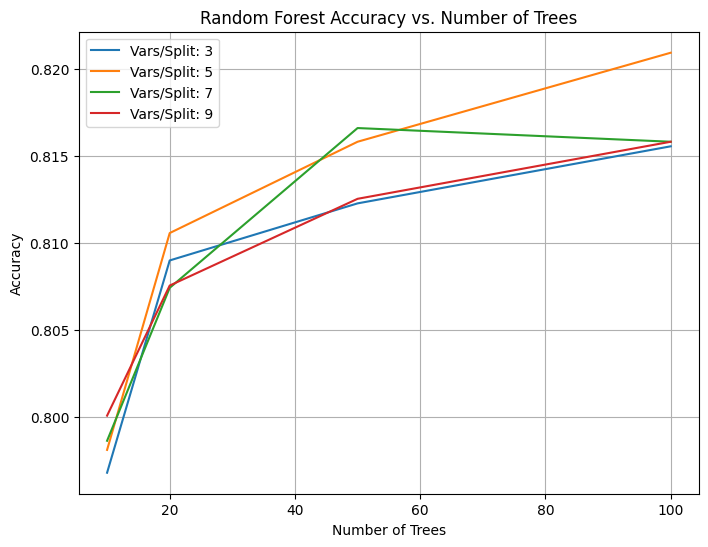

In [ ]:
# Line plot for accuracy across trees
plt.figure(figsize=(8, 6))
for vars_split in hyperparams['variablesPerSplit']:
    subset = results_df[results_df['variablesPerSplit'] == vars_split]
    plt.plot(subset['numberOfTrees'], subset['accuracy'], label=f'Vars/Split: {vars_split}')

plt.title('Random Forest Accuracy vs. Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## Evaluate Model Performance
### Confusion matrix
Next, the trained classifier (best_rf) is applied to the testing dataset (Sample_test) to generate predictions. These predictions are used to calculate a confusion matrix, which compares the true class labels with the predicted ones.

In [ ]:
best_rf = ee.Classifier.smileRandomForest(100, 5).train(
    features=Sample_training,
    classProperty='class',
    inputProperties=bands.getInfo()
)
validation_result = Sample_test.classify(best_rf)
confusion_matrix = validation_result.errorMatrix('class', 'classification')
print('Confusion Matrix:', confusion_matrix.getInfo())
print('Overall Accuracy:', confusion_matrix.accuracy().getInfo())

Confusion Matrix: [[285, 63, 26, 107, 33, 0], [26, 632, 44, 69, 2, 0], [16, 29, 2638, 314, 3, 0], [22, 83, 325, 2273, 66, 0], [14, 5, 16, 86, 347, 2], [4, 4, 0, 2, 3, 78]]
Overall Accuracy: 0.8209268740974137


## Perform land cover classification
### Classification of the composite image
The composite image is classified using the trained best_rf classifier, creating a new image (classified) where each pixel is assigned a land cover class.

In [ ]:
# Classify the composite image
classified = composite.classify(best_rf)

### Legend function
Define a function to add a land cover legend. This function defines a dictionary for the land cover classes and their respective RGB color codes. It adds the legend to the map instance, making it easier for users to understand the displayed land cover classes.

In [ ]:
# Create a function
def add_legend(map_instance):
    legend_dict = {
        "Bare areas": (128, 128, 128),  # grey
        "Built-up": (255, 0, 0),        # red
        "Cropland": (255, 255, 0),      # yellow
        "Grass/open areas": (0, 255, 0),# lime
        "Woodlands": (0, 128, 0),       # green
        "Water": (0, 0, 255),           # blue
    }
    map_instance.add_legend(legend_title="Land Cover Legend", legend_dict=legend_dict)

### Map display function
This function creates a geemap.Map instance and defines a visualization dictionary (viz) with the color palette for each class.


In [ ]:
# Function to create a map instance
def display_map_with_legend(classified_map, title):
    map_instance = geemap.Map()
    palette = ["grey", "red", "yellow", "lime", "green", "blue"]
    viz = {"min": 0, "max": 5, "palette": palette}
    map_instance.centerObject(boundary, 12)
    map_instance.addLayer(classified_map, viz, title)
    map_instance.addLayerControl()
    add_legend(map_instance)  # Add the legend to the map
    return map_instance

### Displaying the land cover map
Finally, display the land cover map. The 'display_map_with_legend' function is called with the classified image and a title. It creates an interactive map (map_rf) with the classified land cover and an accompanying legend.

In [ ]:
# Display land cover
map_rf = display_map_with_legend(classified, "Land cover map")
map_rf

Map(center=[-20.112185699155855, 28.554695214742292], controls=(WidgetControl(options=['position', 'transparen…

### Export the land cover map

Google Earth Engine's Export.image.toDrive() function allows you to save raster data (images) to Google Drive.

In [ ]:
# Define export parameters
export_task = ee.batch.Export.image.toDrive(
    image=classified,  # The classified land cover map
    description='Land_Cover_Map',  # Name of the task
    folder='LC_GEE_Exports',  # Destination folder in Google Drive
    fileNamePrefix='land_cover_map',  # Prefix for the exported file
    region=boundary.geometry(),  # Region of interest
    scale=20,  # Spatial resolution in meters
    maxPixels=1e13  # Max pixels to export
)

# Start the export task
export_task.start()

print("Export task started. Check Google Drive for the exported image.")

Export task started. Check Google Drive for the exported image.
